# Prediction As Classification
Continuing the 2800-HK price prediction from classification perspective

## Step 1: Import Modules and load raw data

In [2]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import keras

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '
Using TensorFlow backend.


In [3]:
#Import sklearn
from sklearn.preprocessing import scale

In [4]:
#Import Keras module
from keras import optimizers
from keras.models import Sequential
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [5]:
#pretty plots
%matplotlib inline

In [6]:
#Import price data
#Load the historical prices of 2800-HK, with lags 1 to lag 20
price_hist_data = pd.read_csv('price_only.csv', skiprows=1, parse_dates=['Date']).set_index(['Date'])
price_hist_data.head()

,P,P_L1,P_L2,P_L3,P_L4,P_L5,P_L6,P_L7,P_L8,P_L9,...,P_L11,P_L12,P_L13,P_L14,P_L15,P_L16,P_L17,P_L18,P_L19,P_L20
Date,,,,,,,,,,,,,,,,,,,,,
2007-08-31,24.35,23.80,23.35,23.70,23.90,23.30,23.35,22.70,22.05,21.85,...,20.95,21.70,22.35,22.30,22.05,22.70,22.85,22.15,22.25,22.85
2007-09-03,24.30,24.35,23.80,23.35,23.70,23.90,23.30,23.35,22.70,22.05,...,20.80,20.95,21.70,22.35,22.30,22.05,22.70,22.85,22.15,22.25
2007-09-04,24.30,24.30,24.35,23.80,23.35,23.70,23.90,23.30,23.35,22.70,...,21.85,20.80,20.95,21.70,22.35,22.30,22.05,22.70,22.85,22.15
2007-09-05,24.35,24.30,24.30,24.35,23.80,23.35,23.70,23.90,23.30,23.35,...,22.05,21.85,20.80,20.95,21.70,22.35,22.30,22.05,22.70,22.85
2007-09-06,24.50,24.35,24.30,24.30,24.35,23.80,23.35,23.70,23.90,23.30,...,22.70,22.05,21.85,20.80,20.95,21.70,22.35,22.30,22.05,22.70


In [7]:
#Import Fundamentals Data
fund_data = pd.read_csv('new_index_data.csv', skiprows=1, parse_dates=['Date']).set_index(['Date'])
fund_data.head() 

,Close,High,Low,Ask,Bid,20D Vol,MA5,MA15,MA12,MA20,...,DY_LTM,DY_NTM,ADV_VOL,PAYOUT,ANALYST_SENTIMENT,EPS_GRW_FY1,EPS_GRW_FY2,PE_NTM,PE_LTM,C2D_LTM
Date,,,,,,,,,,,,,,,,,,,,,
2007-08-31,24.35,24.35,24.35,24.35,24.35,2.367823,23.82,22.841667,22.696667,22.6225,...,2.782797,2.880128,99.419898,48.051962,1.909071,30.724490,2.717280,16.695058,16.975805,58.050474
2007-09-03,24.30,24.30,24.30,24.30,24.30,2.266743,23.90,23.120832,22.830000,22.7250,...,2.784563,2.892308,11.570023,48.305678,1.835359,31.005439,1.876752,16.709085,16.925571,58.154835
2007-09-04,24.30,24.30,24.30,24.30,24.30,2.259649,24.02,23.412500,22.960000,22.8325,...,2.784339,2.894377,69.555725,48.307102,1.725886,31.040968,1.891823,16.697662,16.919413,58.177640
2007-09-05,24.35,24.35,24.35,24.35,24.35,2.172140,24.22,23.620832,23.136667,22.9075,...,2.767348,2.867314,24.265623,48.267351,1.741908,30.716929,1.878484,16.841225,17.017692,58.195446
2007-09-06,24.50,24.50,24.50,24.50,24.50,2.160638,24.36,23.825000,23.373333,22.9975,...,2.775339,2.878880,88.845002,48.288397,1.696151,31.336520,1.861943,16.780660,16.975485,58.224743


In [8]:
#Import Global index data
idx_data = pd.read_csv('indices.csv', skiprows=1, parse_dates=['Date']).set_index(['Date'])
idx_data.head()

,Hang Seng Index,SSE Composite Index,ASX All Ordinaries,India S&P BSE SENSEX,TOPIX,KOSPI Composite Index,Taiwan TAIEX,FTSE Bursa Malaysia KLCI,FTSE Straits Times Index,Philippines PSE PSEi,...,Turkey BIST 100,S&P 500,DJ Industrial Average,Colombia IGBC,Canada S&P/TSX Composite,Brazil Bovespa Index,Mexico IPC,Israel TA-125,Saudi Arabia All Share (TASI),FTSE JSE All Share
Date,,,,,,,,,,,,,,,,,,,,,
2007-08-31,23984.14,5218.825,6248.3,15318.60,1608.25,1873.24,8982.16,1273.93,3328.43,3365.29,...,50198.60,1473.99,13357.74,10728.74,13660.48,54637.24,30347.86,1034.67,8226.97,28660.35
2007-09-03,23904.09,5321.055,6272.5,15422.05,1605.44,1881.81,8979.96,1284.14,3321.36,3369.14,...,49936.94,1473.99,13357.74,10750.79,13660.48,54832.51,30797.60,1047.33,8017.54,28887.48
2007-09-04,23886.07,5294.045,6297.1,15465.40,1596.74,1874.74,8922.98,1283.75,3308.81,3312.30,...,50032.59,1489.42,13448.86,10880.85,13755.23,55250.47,30932.71,1054.69,7878.70,29051.96
2007-09-05,24069.17,5310.716,6274.3,15446.15,1569.47,1865.59,8913.85,1297.93,3375.02,3342.35,...,49421.38,1472.29,13305.47,10819.91,13683.28,54407.83,30809.55,1048.70,7853.66,28696.67
2007-09-06,24050.40,5393.660,6265.3,15616.31,1568.52,1888.81,9017.08,1298.85,3399.49,3326.53,...,49601.39,1478.55,13363.35,10844.40,13795.69,54569.00,30816.95,1033.23,7853.66,28850.19


## Step 2: Pre-process Raw Data
1. Generate labels
2. Apply lags to global index data
3. Normalize features

In [9]:
#Generate Labels from Price History Data
#Generate UP/DOWN labels from log change
cutoff_perc = 0.0005 #0.05% return as cuttoff to define UP label
lag = 1 #forward returns

labels = np.zeros([price_hist_data.shape[0]])

#Caluclate log-returns
ret = np.log(price_hist_data['P'].shift(-lag)/price_hist_data['P'])
labels = [1 if r > cutoff_perc else 0 for r in ret]

In [10]:
#Applying lags to index data
#Seperate the indices into 2 classes - lag or no_lag
no_lag = [0, 1, 2, 4, 5, 6, 9, 10]
lag = [i for i in range(0,idx_data.shape[1]) if i not in no_lag]

#Processing the dataset by applying appropriate lags
lagged_data = idx_data.iloc[:,lag].shift(1)
idx_data = pd.concat([idx_data.iloc[:,no_lag], lagged_data], axis=1)


In [11]:
#Remove first row
idx_data = idx_data.iloc[1:, :]
price_hist_data = price_hist_data.iloc[1:, :]
fund_data = fund_data.iloc[1:, :]
labels=labels[1:]

In [12]:
#Check Dimensions to make sure everythings right before continuing..
print("Shape of idx_data: ", idx_data.shape)
print("Shape of price_hist_data: ", price_hist_data.shape)
print("Shape of fund_data: ", fund_data.shape)
print("Shape of labels: ", len(labels))

Shape of idx_data:  (2483, 42)
Shape of price_hist_data:  (2483, 21)
Shape of fund_data:  (2483, 30)
Shape of labels:  2483


In [13]:
#Training data
X = np.array(pd.concat([price_hist_data, idx_data, fund_data], axis=1))
y = to_categorical(labels, num_classes=2)

In [14]:
#Checking whether there are NAs
[np.sum(np.isnan(X), axis=0) > 0] == True

False

## Step 3: Split training, validation and test set

In this stage we have a look-ahead bias free set of data (X) and the labels y. Next, we will need to:
- Normalize the input data. To avoid look ahead bias, we will z-score the features, using ONLY the training set.
- Next, generate input data into LSTM network. We will need an overlapping sequence at 1-day window as input samples. Specifically suppose the *timestep* is 240, we will have a list of array consists of *number of rows of X* - 240 entries, each element has dimentions (240, num_of_features)


In [15]:
#Function to split raw data into training, validation and test set, returns a numpy array.
def split_data(input_data=[], train_size=0.8, val_size=0.2, test_size=0):
    
    #------------------------------------------------
    #PARAM: input_data: numpy nd array
    #PARAM: training_size: size of training set in decimal
    #PARAM: val_size: size of validation set in decimal
    #PARAM: test_size: size of test set in decimal
    #OUTPUT: tuple (train_set, validation_set, test_set)
    #------------------------------------------------
    
    #First check whether traing_size + val_size + test_size = 1 and each of the entries are positive
    assert(train_size + val_size + test_size==1), "Sum of training, validation and test size needs to be 1!"
    assert(train_size * val_size * test_size > 0), "Sizes have to be positive!"
    
    #Check input_data type is numpy array, after casting
    if type(input_data) != 'numpy.ndarray':
        input_data = np.array(input_data) 
    
    assert(isinstance(input_data, np.ndarray)), "Input has to be a numpy array!"
    
    
    #Calculate cut-off points
    train_cut_index = int(train_size * input_data.shape[0])
    val_cut_index = train_cut_index + int(val_size * input_data.shape[0])
    
    #Split the data
    if len(input_data.shape) == 1:
        train, val, test = input_data[:train_cut_index], input_data[train_cut_index:val_cut_index], input_data[val_cut_index:]
    else:
        train, val, test = input_data[:train_cut_index,:], input_data[train_cut_index:val_cut_index, :], input_data[val_cut_index:, :]
    
    return train, val, test

In [16]:
#------------
#TEST OUTPUT
#------------
#Split data
X_train, X_val, X_test = split_data(X, train_size=0.6, val_size=0.2, test_size=0.2)
y_train, y_val, y_test = split_data(y, train_size=0.6, val_size=0.2, test_size=0.2)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1489, 93)
(496, 93)
(498, 93)
(1489, 2)
(496, 2)
(498, 2)


In [17]:
#Function to re-structure the data to get batches. Re-shape the data to have overlapping training set for time-series learning.
def get_inputs(input_data, labels, batch_size, timesteps):
    
    #First get the total number of samples generated
    n_seq = input_data.shape[0] - timesteps + 1
    
    #features, classes
    n_dim = input_data.shape[1]
    n_class = labels.shape[1]
    
    #Calculate the number of batches possible
    n_samples = n_seq * timesteps
    n_batches = n_samples // (batch_size * timesteps)

    output = []
    targets = []
        
    for jj in range(0, n_batches):
    #Generate the sequences
        
        #if jj == n_batches:
            
            #output.append([input_data[jj*batch_size:, :]])
            #targets.append([labels[jj*batch_size:, :]])            
            #yield np.vstack(output), np.vstack(targets  )
            
        #else:            
        for ii in range(jj * batch_size, (jj + 1) * batch_size):                    
            #Getting the overlapping samples
            output.append([scale(input_data[ii:ii + timesteps, :])])
            targets.append([labels[ii:ii+timesteps, :]])

    return np.vstack(output), np.vstack(targets)


In [18]:
#------------
#TEST OUTPUT
#------------
#get inputs
t = np.reshape(np.arange(1,51), (10,5))
s = np.reshape(np.arange(1,21), (10,2))

#for (x, y) in get_inputs(t,s, 3, 4):
#    print('training size: ', x.shape)
#    print('training: \n', x)
#    print('label size: ', y.shape)
#    print('labels: \n', y)

test_train, test_label = get_inputs(t,s,3,4)
    

#print(test_train[0:1])
#print(test_label[0:1])
#print(t)
print(test_train.shape)
print(test_label.shape)
#print(test_train)
#test_train.reshape((-1, 4, 5))

(6, 4, 5)
(6, 4, 2)


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


## Step 4: Train Model

In [19]:
#Define Parameters
learning_rate = 0.0001
epochs= 100
loss = 'binary_crossentropy'
batch_size = 128
timesteps = 22
n_dim = X.shape[1]
n_classes = 2

#Optimizer
optimizer = optimizers.Adam(lr=learning_rate)

In [20]:
X_train, y_train = get_inputs(X_train, y_train, batch_size, timesteps)
X_val, y_val = get_inputs(X_val, y_val, batch_size, timesteps)
X_test, y_test = get_inputs(X_test, y_test, batch_size, timesteps)

In [21]:
#Define LSTM Network object
def build_network(n_hidden_layer, dropout, input_shape, batch_size, return_sequences=True, stateful=True):
    
    #Define network architect
    model = Sequential()
    model.add(LSTM(n_hidden_layer[0], input_shape=input_shape, batch_size=batch_size, return_sequences=return_sequences, stateful=stateful))
    model.add(Dropout(dropout[0]))
    model.add(LSTM(n_hidden_layer[1], return_sequences=return_sequences, stateful=stateful))
    model.add(Dropout(dropout[1]))
    model.add(Dense(n_hidden_layer[2], activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    
    return model

In [22]:
lstm1 = build_network([5,5,10], [0.3,0.3], input_shape=(timesteps, n_dim), batch_size=batch_size)

In [23]:
#Compile
lstm1.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [24]:
fitted = lstm1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_val, y_val), shuffle=True)

## Step 5: Evaluate


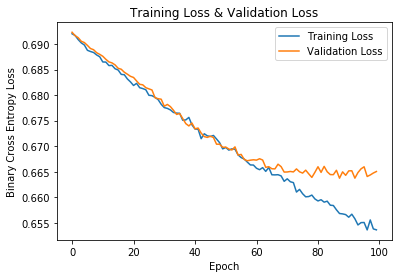

In [25]:
### Plot Training vs Validation Curve
plt.figure()
plt.plot(fitted.history['loss'])
plt.plot(fitted.history['val_loss'])
plt.title('Training Loss & Validation Loss')
plt.ylabel('Binary Cross Entropy Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

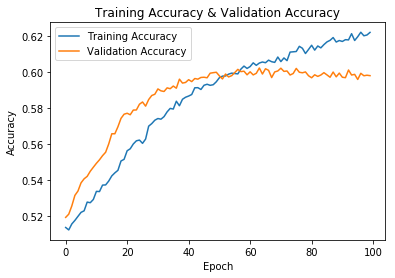

In [26]:
### Plot Training vs Validation Accuracy
plt.figure()
plt.plot(fitted.history['acc'])
plt.plot(fitted.history['val_acc'])
plt.title('Training Accuracy & Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

## Step 6: Parameter Tuning


Grid Search the following parameters:
- Learning Rate & decay rate
- Number of Hidden Layers
- Dropout Rate
- Timesteps

### Learning Rate

In [ ]:
#Grid Search for learning rate, at fixed 100 epochs.
lr = np.linspace(1e-5, 1e-3, 100)

In [ ]:
#Initiate empty list to store best validation loss for a particular learning rate
lr_loss = []
steps = 1

#Build network
lr_network = build_network([5,5,10], [0,0], input_shape=(timesteps, n_dim), batch_size=batch_size)

#Loop through the learning rate and train network
for learning_rate in lr:
    
    #Optimizer
    optimizer = optimizers.Adam(lr=learning_rate)
    
    #Compile
    lr_network.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    
    #Train
    fitted = lr_network.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_val, y_val), shuffle=True)
    
    #Display
    print('Steps: %d, learning rate: %.6f, Best Validation Loss: %.4f' %(steps, learning_rate, np.min(fitted.history['val_loss'])))
    
    #Save
    lr_loss.append([np.min(fitted.history['val_loss'])])
    
    #Update
    steps += 1

Steps: 1, learning rate: 0.000010, Best Validation Loss: 0.6917
Steps: 2, learning rate: 0.000020, Best Validation Loss: 0.6869
Steps: 3, learning rate: 0.000030, Best Validation Loss: 0.6777
Steps: 4, learning rate: 0.000040, Best Validation Loss: 0.6681
Steps: 5, learning rate: 0.000050, Best Validation Loss: 0.6653
Steps: 6, learning rate: 0.000060, Best Validation Loss: 0.6674
Steps: 7, learning rate: 0.000070, Best Validation Loss: 0.6789
Steps: 8, learning rate: 0.000080, Best Validation Loss: 0.6963
Steps: 9, learning rate: 0.000090, Best Validation Loss: 0.7174
Steps: 10, learning rate: 0.000100, Best Validation Loss: 0.7370
Steps: 11, learning rate: 0.000110, Best Validation Loss: 0.7592
Steps: 12, learning rate: 0.000120, Best Validation Loss: 0.7776
Steps: 13, learning rate: 0.000130, Best Validation Loss: 0.8055
Steps: 14, learning rate: 0.000140, Best Validation Loss: 0.8415
Steps: 15, learning rate: 0.000150, Best Validation Loss: 0.8747
Steps: 16, learning rate: 0.000160

In [47]:
#Best Learning Rate
best_lr = lr[np.argmin(lr_loss)]
print('Best Learning Rate: %.5f' % best_lr)
%store best_lr
%store lr_loss


Best Learning Rate: 0.00005
Stored 'best_lr' (float64)
Stored 'lr_loss' (list)


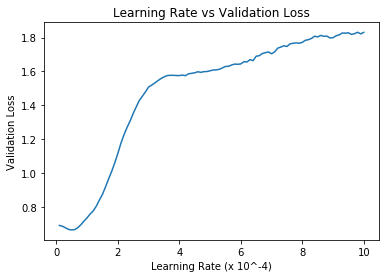

In [38]:
#Plot Relationship
plt.plot(lr*1e4, lr_loss)
plt.title('Learning Rate vs Validation Loss')
plt.xlabel('Learning Rate (x 10^-4)')
plt.ylabel('Validation Loss')
plt.show()

## Decay Rate